# Run analysis: 

This notebook analyzes search logs and forecasts for the run in `data/runs/20260131_122311_51043`.


In [308]:
from pathlib import Path
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

RUN_DIR = Path('../data/runs/20260131_122311_51043')
WEEKS_CSV = Path('../data/weeks.csv')

pd.set_option('display.max_columns', 50)
plt.style.use('seaborn-v0_8')


In [309]:
PARTY_COLORS = {
    "People's Party": "#FF6413",
    "Bhumjaithai Party": "#082680",
    "Pheu Thai Party": "#D9000D",
    "Democrat Party (Thailand)": "#0078B9",
    "Kla Tham Party": "#2E7D32",
    "Other": "#9E9E9E",
}


## Weeks covered

In [310]:
weeks = pd.read_csv(WEEKS_CSV)
weeks

,week_index,week_start,week_end
0,0,2025-12-12,2025-12-21
1,1,2025-12-22,2025-12-28
2,2,2025-12-29,2026-01-04
3,3,2026-01-05,2026-01-11
4,4,2026-01-12,2026-01-18
5,5,2026-01-19,2026-01-25
6,6,2026-01-26,2026-01-31


## Search logs: coverage and volume

In [311]:
def load_search_logs(run_dir: Path):
    rows = []
    for model_dir in (run_dir / 'search_logs').glob('*'):
        for path in model_dir.glob('*.json'):
            data = json.loads(path.read_text())
            sources = data.get('sources') or []
            publishers = [s.get('publisher') for s in sources if isinstance(s, dict)]
            rows.append({
                'week_start': data.get('week_start'),
                'week_end': data.get('week_end'),
                'model': data.get('model', model_dir.name),
                'n_queries': len(data.get('queries') or []),
                'n_sources': len(sources),
                'n_publishers': len({p for p in publishers if p}),
                'path': str(path),
            })
    return pd.DataFrame(rows)

search_df = load_search_logs(RUN_DIR)
search_df.sort_values(['week_start','model'])

,week_start,week_end,model,n_queries,n_sources,n_publishers,path
8,2025-12-12,2025-12-21,gemini-3-pro-preview,5,15,13,../data/runs/20260131_122311_51043/search_logs...
1,2025-12-12,2025-12-21,gpt-5.2,8,7,5,../data/runs/20260131_122311_51043/search_logs...
10,2025-12-22,2025-12-28,gemini-3-pro-preview,5,15,14,../data/runs/20260131_122311_51043/search_logs...
3,2025-12-22,2025-12-28,gpt-5.2,7,16,10,../data/runs/20260131_122311_51043/search_logs...
7,2025-12-29,2026-01-04,gemini-3-pro-preview,5,15,10,../data/runs/20260131_122311_51043/search_logs...
0,2025-12-29,2026-01-04,gpt-5.2,5,2,2,../data/runs/20260131_122311_51043/search_logs...
12,2026-01-05,2026-01-11,gemini-3-pro-preview,5,15,13,../data/runs/20260131_122311_51043/search_logs...
5,2026-01-05,2026-01-11,gpt-5.2,5,5,5,../data/runs/20260131_122311_51043/search_logs...
11,2026-01-12,2026-01-18,gemini-3-pro-preview,6,15,11,../data/runs/20260131_122311_51043/search_logs...
4,2026-01-12,2026-01-18,gpt-5.2,8,9,5,../data/runs/20260131_122311_51043/search_logs...


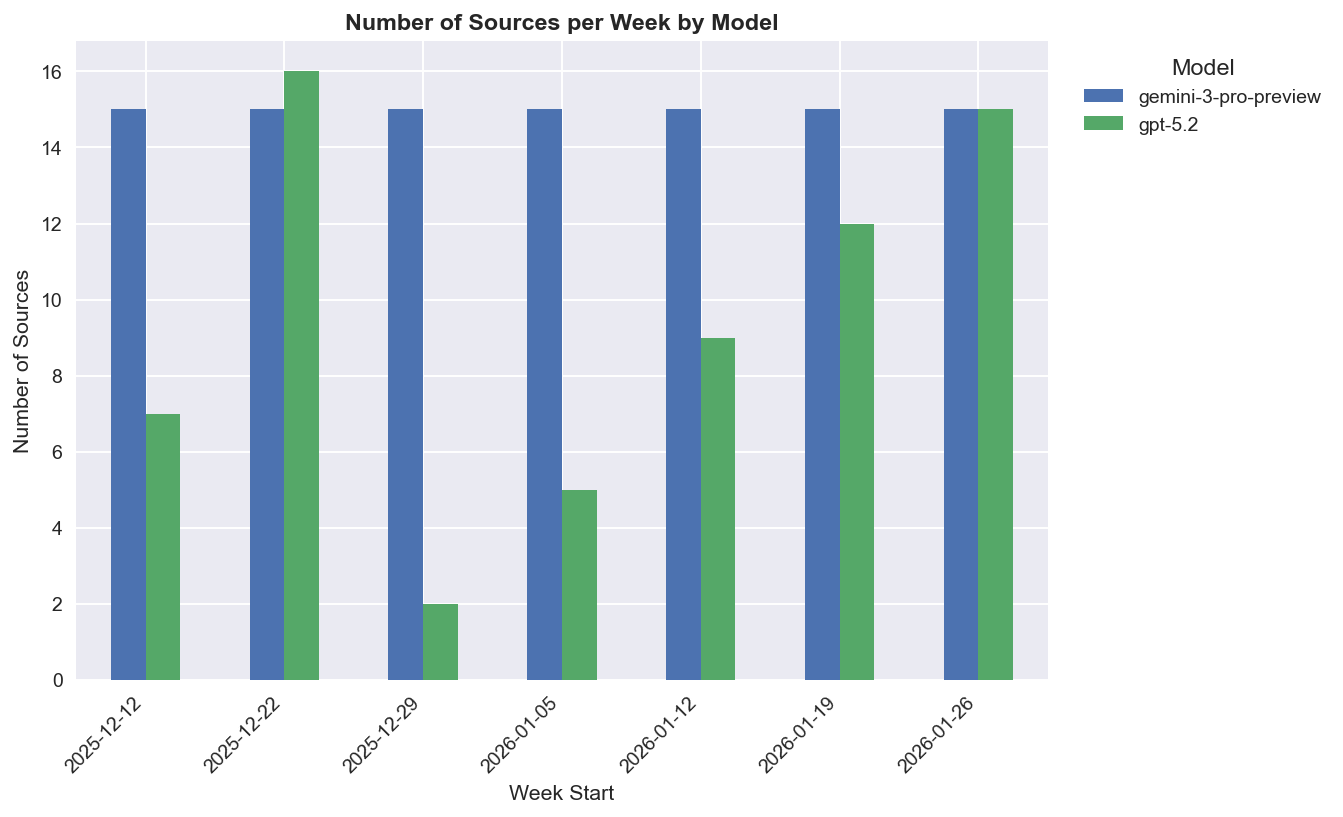

In [312]:
# Sources per week, side-by-side bars by model
if search_df.empty:
    print('No search log data')
else:
    pivot = (
        search_df
        .pivot_table(index='week_start', columns='model', values='n_sources', aggfunc='sum')
        .fillna(0)
        .sort_index()
    )

    ax = pivot.plot(kind='bar', figsize=(10, 6))
    ax.set_title('Number of Sources per Week by Model')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_xlabel('Week Start')
    ax.set_ylabel('Number of Sources')
    ax.legend(title='Model', loc="upper right", bbox_to_anchor=(1.3, 1))
    plt.tight_layout()
    plt.show()

## Search logs: top publishers

In [313]:
def explode_publishers(run_dir: Path):
    rows = []
    for model_dir in (run_dir / 'search_logs').glob('*'):
        for path in model_dir.glob('*.json'):
            data = json.loads(path.read_text())
            sources = data.get('sources') or []
            for s in sources:
                if not isinstance(s, dict):
                    continue
                rows.append({
                    'week_start': data.get('week_start'),
                    'model': data.get('model', model_dir.name),
                    'publisher': s.get('publisher') or 'Unknown',
                    'url': s.get('url'),
                })
    return pd.DataFrame(rows)

pub_df = explode_publishers(RUN_DIR)
pd.set_option('display.max_rows', 100)

# Normalize publisher strings to reduce duplicates
PUBLISHER_MAP = {
    # Thai PBS
    'ThaiPBS': 'Thai PBS',
    'ThaiPBS (The Active)': 'Thai PBS',

    # THE STANDARD
    'The Standard': 'THE STANDARD',
    'THE STANDARD (Wealth/Tech)': 'THE STANDARD',
    'THE STANDARD (WEALTH)': 'THE STANDARD',

    # InfoQuest
    'อินโฟเควสท์ (InfoQuest)': 'InfoQuest',
    'RYT9 / InfoQuest': 'InfoQuest',

    # Thairath
    'ไทยรัฐ': 'Thairath',
    'ไทยรัฐออนไลน์': 'Thairath',
    'Thairath Online': 'Thairath',
    'Thairath Online (ไทยรัฐออนไลน์)': 'Thairath',
    'Thairath (English)': 'Thairath',
    'ไทยรัฐ (Thairath)': 'Thairath',

    # Bangkok Biz News
    'กรุงเทพธุรกิจ (Bangkok Biz News)': 'Bangkok Biz News',
    'กรุงเทพธุรกิจ (BangkokBizNews)': 'Bangkok Biz News',
    'กรุงเทพธุรกิจ': 'Bangkok Biz News',

    # Naewna
    'แนวหน้า (Naewna)': 'Naewna',
    'แนวหน้า': 'Naewna',

    # Post Today
    'PostToday': 'Post Today',

    # Matichon
    'มติชน (Matichon)': 'Matichon',
    'มติชนออนไลน์': 'Matichon',
    'Matichon Online (มติชนออนไลน์)': 'Matichon',
    'มติชนสุดสัปดาห์ (Matichon Weekly)': 'Matichon',

    # Daily News
    'เดลินิวส์': 'Daily News',
    'Dailynews': 'Daily News',
    'Daily News': 'Daily News',
    'เดลินิวส์ (Daily News)': 'Daily News',
    'Daily News (เดลินิวส์)': 'Daily News',

    # PPTV
    'PPTVHD36': 'PPTV',
    'PPTV HD 36': 'PPTV',

    # Khaosod
    'ข่าวสด (Khaosod)': 'Khaosod',
    'ข่าวสด': 'Khaosod',

    # Nation
    'Nation TV': 'Nation',
    'The Nation (Thailand)': 'Nation',
    'Nation Thailand': 'Nation',

    # Thai Post
    'ไทยโพสต์ (Thaipost)': 'Thai Post',
    'Thaipost': 'Thai Post',

    # Line Today
    'Line Today (AEC10NEWS)': 'Line Today',
    'Line Today / FM91': 'Line Today',
    'Line Today / The Room 44': 'Line Today',
    'Line Today / SorWorPor91': 'Line Today',

    # YouTube platform
    'Youtube (News Summary)': 'YouTube',
    'YouTube (CEO Talk)': 'YouTube',
    'YouTube (Ch3 Thailand)': 'YouTube',
    'YouTube (K Securities)': 'YouTube',
    'YouTube (TOP NEWS)': 'YouTube',
    'YouTube (MCOT)': 'YouTube',
    'Voice TV / YouTube': 'YouTube',

    # Isranews
    'สำนักข่าวอิศรา (Isranews)': 'Isranews',
}

pub_df['publisher_norm'] = pub_df['publisher'].map(PUBLISHER_MAP).fillna(pub_df['publisher'])

print(pub_df['publisher_norm'].value_counts())

publisher_norm
Thai PBS                        19
Thairath                        16
THE STANDARD                    14
Bangkok Biz News                13
Matichon                         9
Naewna                           8
Daily News                       7
Thai Post                        7
InfoQuest                        7
Line Today                       7
YouTube                          7
PPTV                             6
Post Today                       6
Nation                           5
Prachatai                        4
Khaosod                          3
Top News                         3
Isranews                         2
RYT9                             2
AEC10NEWS                        2
Thai Enquirer                    2
บ้านเมือง (Banmuang)             1
INN News                         1
NIDA Poll (นิด้าโพล)             1
Kasikorn Asset Management        1
Pheu Thai Party Official         1
Songkanong SAO                   1
Samila Times                     1
KSAO 

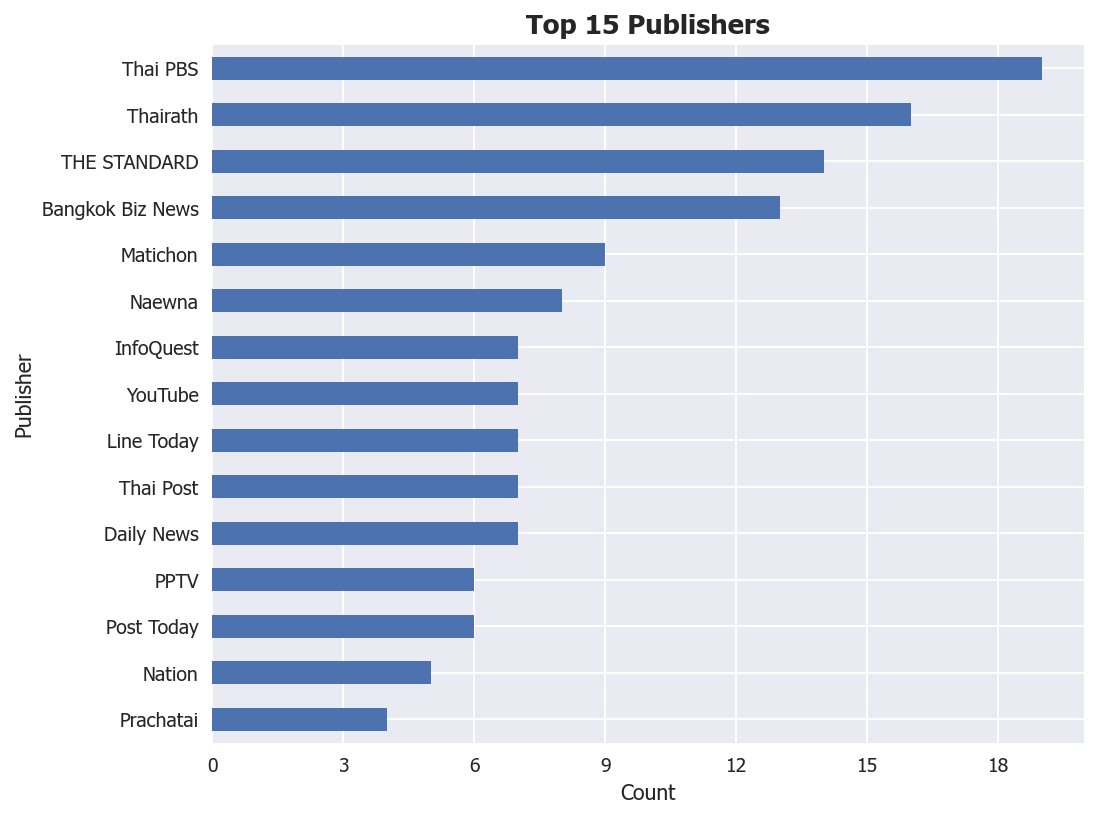

In [333]:
plt.rcParams['font.family'] = [ 'Tahoma', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

if pub_df.empty:
    print('No publisher data')
else:
    pub_counts = pub_df['publisher_norm'].value_counts().sort_values()
    ax = pub_counts.tail(15).plot(kind='barh', figsize=(8, 6))
    ax.set_xticks(range(0, pub_counts.max()+1, 3))
    ax.set_title('Top 15 Publishers')
    ax.set_xlabel('Count')
    ax.set_ylabel('Publisher')
    plt.tight_layout()
    plt.show()

## Precomputed analysis outputs

In [315]:
analysis_dir = RUN_DIR / 'analysis' / 'news'
summary = pd.read_csv(analysis_dir / 'search_summary.csv')
publishers = pd.read_csv(analysis_dir / 'publisher_counts.csv')
duplicates = pd.read_csv(analysis_dir / 'duplicate_urls.csv')

summary.head(), publishers.head(), duplicates.head()

(   week_start    week_end    model  source_count  unique_publishers  \
 0  2025-12-29  2026-01-04  gpt-5.2             2                  2   
 1  2025-12-12  2025-12-21  gpt-5.2             7                  5   
 2  2026-01-26  2026-01-31  gpt-5.2            15                 10   
 3  2025-12-22  2025-12-28  gpt-5.2            16                 10   
 4  2026-01-12  2026-01-18  gpt-5.2             9                  5   
 
    query_count  excluded_count  
 0            5              11  
 1            8               4  
 2           11               5  
 3            7               5  
 4            8               6  ,
    week_start    week_end    model                          publisher  count
 0  2025-12-29  2026-01-04  gpt-5.2                  ไทยรัฐ (Thairath)      1
 1  2025-12-29  2026-01-04  gpt-5.2  มติชนสุดสัปดาห์ (Matichon Weekly)      1
 2  2025-12-12  2025-12-21  gpt-5.2     กรุงเทพธุรกิจ (BangkokBizNews)      3
 3  2025-12-12  2025-12-21  gpt-5.2  มติชนสุดสัปด

## Forecasts: totals over time

In [316]:
def load_forecasts(run_dir: Path):
    rows = []
    for model_dir in (run_dir / 'forecasts').glob('*'):
        for path in model_dir.glob('*.json'):
            data = json.loads(path.read_text())
            condition = data.get('condition')
            if condition is None:
                condition = 'no_prior' if path.name.endswith('.no_prior.json') else 'with_prior'
            totals = data.get('forecast_total') or {}
            row = {
                'week_start': data.get('week_start'),
                'week_end': data.get('week_end'),
                'model': data.get('model', model_dir.name),
                'condition': condition,
                'path': str(path),
            }
            for party, seats in totals.items():
                row[party] = seats
            rows.append(row)
    return pd.DataFrame(rows)

fcst = load_forecasts(RUN_DIR)
fcst.sort_values(['week_start','model','condition']).head()

,week_start,week_end,model,condition,path,People's Party,Bhumjaithai Party,Pheu Thai Party,Democrat Party (Thailand),Kla Tham Party,Other
22,2025-12-12,2025-12-21,gemini-3-pro-preview,no_prior,../data/runs/20260131_122311_51043/forecasts/g...,143,137,117,23,0,80
9,2025-12-12,2025-12-21,gpt-5.2,no_prior,../data/runs/20260131_122311_51043/forecasts/g...,194,78,136,21,3,68
24,2025-12-22,2025-12-28,gemini-3-pro-preview,no_prior,../data/runs/20260131_122311_51043/forecasts/g...,163,103,138,26,10,60
18,2025-12-22,2025-12-28,gemini-3-pro-preview,with_prior,../data/runs/20260131_122311_51043/forecasts/g...,143,139,115,25,9,69
11,2025-12-22,2025-12-28,gpt-5.2,no_prior,../data/runs/20260131_122311_51043/forecasts/g...,159,70,131,25,10,105


In [317]:
# Filter only condition == 'with_prior'
fcst = fcst[fcst['condition'] == 'with_prior']
fcst

,week_start,week_end,model,condition,path,People's Party,Bhumjaithai Party,Pheu Thai Party,Democrat Party (Thailand),Kla Tham Party,Other
1,2025-12-29,2026-01-04,gpt-5.2,with_prior,../data/runs/20260131_122311_51043/forecasts/g...,200,78,133,21,5,63
4,2026-01-26,2026-01-31,gpt-5.2,with_prior,../data/runs/20260131_122311_51043/forecasts/g...,225,72,121,23,5,54
5,2025-12-22,2025-12-28,gpt-5.2,with_prior,../data/runs/20260131_122311_51043/forecasts/g...,200,78,133,21,5,63
7,2026-01-12,2026-01-18,gpt-5.2,with_prior,../data/runs/20260131_122311_51043/forecasts/g...,202,77,130,20,5,66
8,2026-01-05,2026-01-11,gpt-5.2,with_prior,../data/runs/20260131_122311_51043/forecasts/g...,208,75,128,20,5,64
12,2026-01-19,2026-01-25,gpt-5.2,with_prior,../data/runs/20260131_122311_51043/forecasts/g...,218,72,126,20,5,59
14,2025-12-29,2026-01-04,gemini-3-pro-preview,with_prior,../data/runs/20260131_122311_51043/forecasts/g...,144,142,115,25,9,65
17,2026-01-26,2026-01-31,gemini-3-pro-preview,with_prior,../data/runs/20260131_122311_51043/forecasts/g...,150,152,96,35,17,50
18,2025-12-22,2025-12-28,gemini-3-pro-preview,with_prior,../data/runs/20260131_122311_51043/forecasts/g...,143,139,115,25,9,69
20,2026-01-12,2026-01-18,gemini-3-pro-preview,with_prior,../data/runs/20260131_122311_51043/forecasts/g...,149,144,111,25,14,57


In [318]:
# Melt to long format for plotting
if not fcst.empty:
    party_cols = [c for c in fcst.columns if c not in {'week_start','week_end','model','condition','path'}]
    long = fcst.melt(id_vars=['week_start','model','condition'], value_vars=party_cols, var_name='party', value_name='seats')
    long = long.sort_values(['party','week_start','model','condition'])
    long.head()

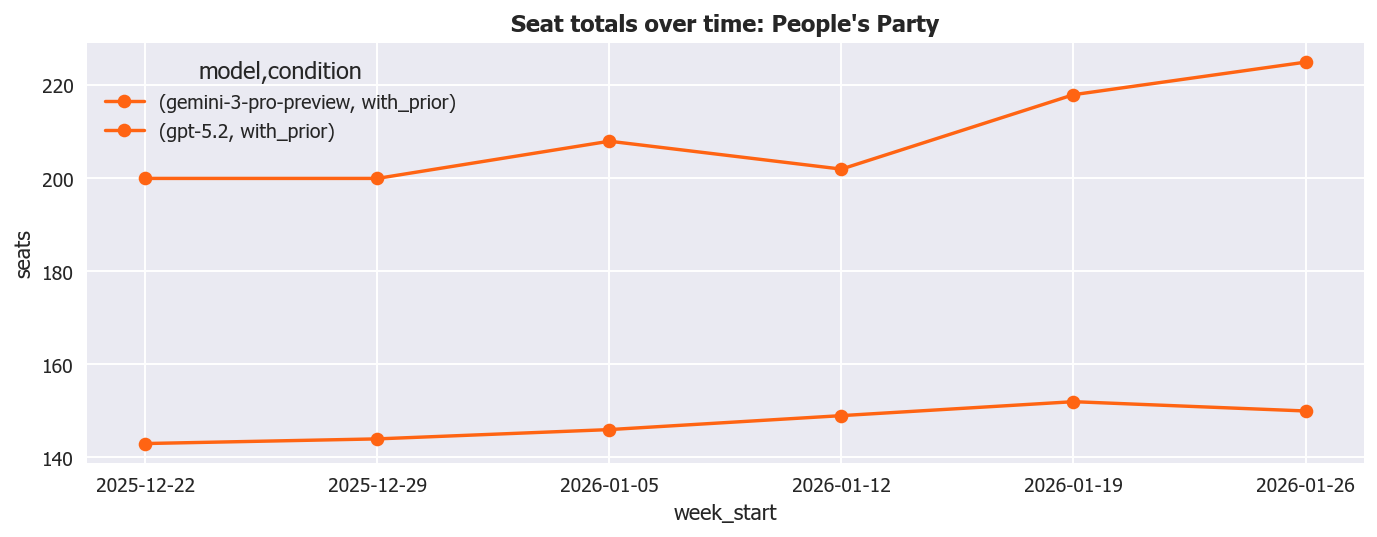

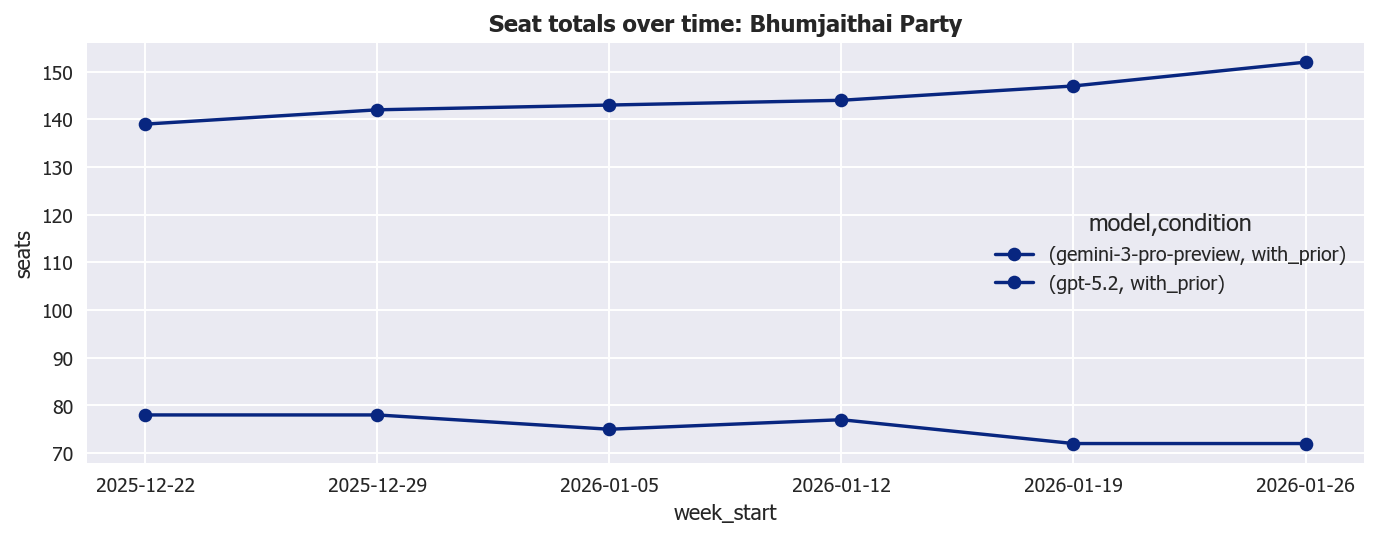

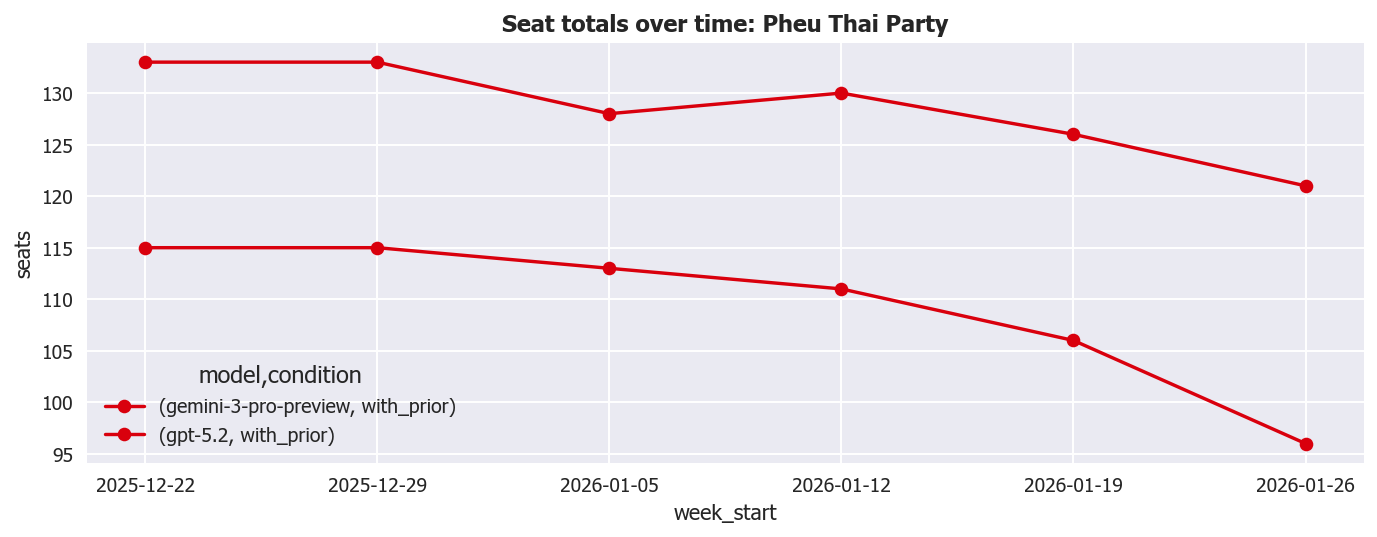

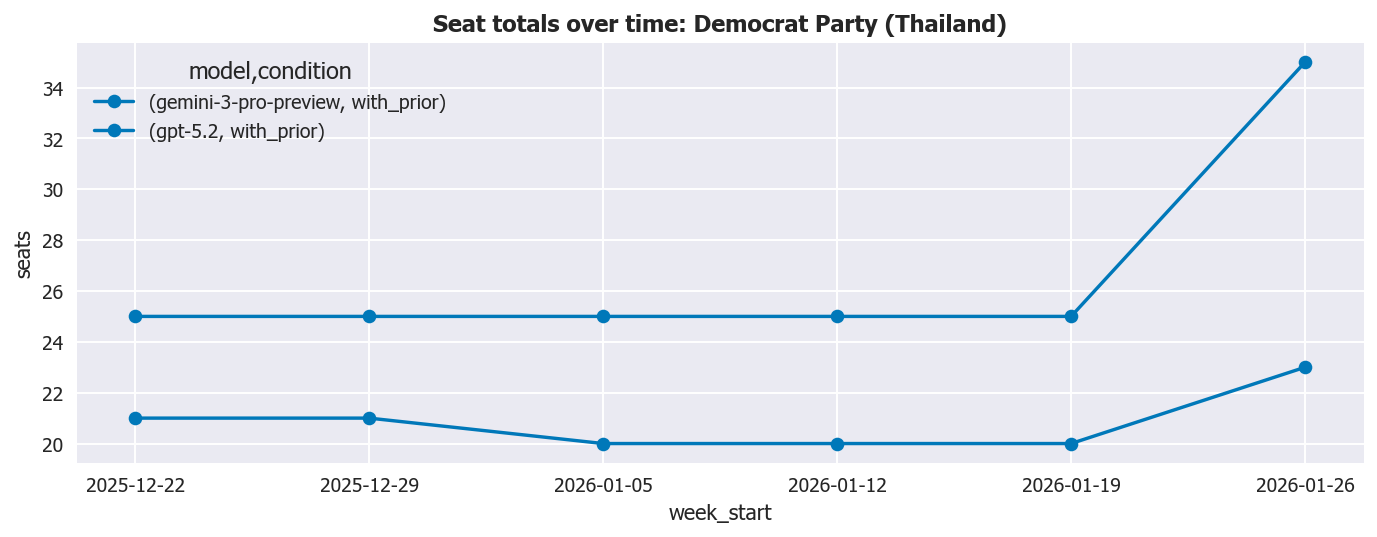

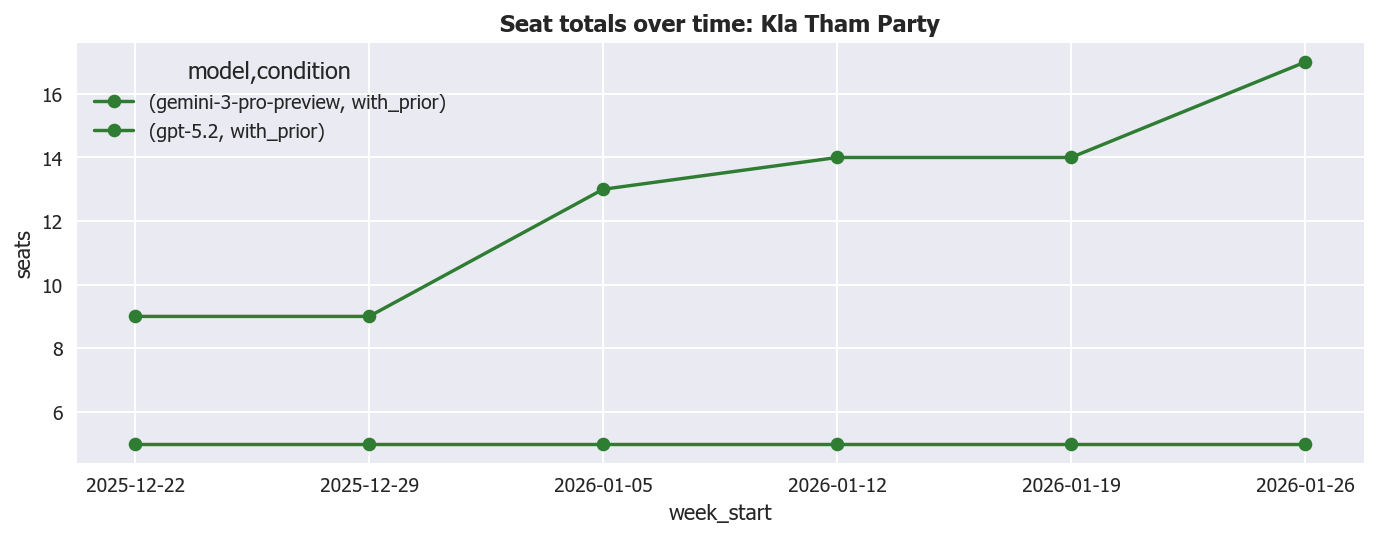

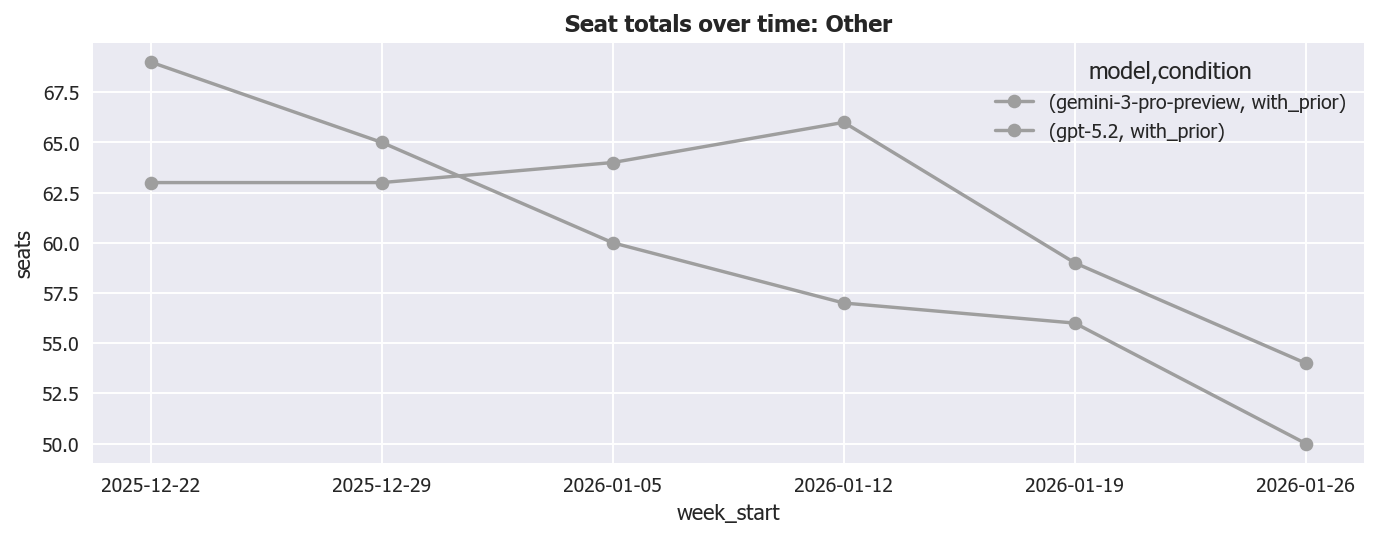

In [319]:
# Plot totals over time for each party and model/condition
if not fcst.empty:
    party_cols = [c for c in fcst.columns if c not in {'week_start','week_end','model','condition','path'}]
    for party in party_cols:
        color = PARTY_COLORS.get(party, '#999999')
        ax = fcst.pivot_table(index='week_start', columns=['model','condition'], values=party, aggfunc='mean').plot(
            figsize=(10,4), marker='o', color=color, title=f'Seat totals over time: {party}'
        )
        ax.set_ylabel('seats')
        plt.tight_layout()


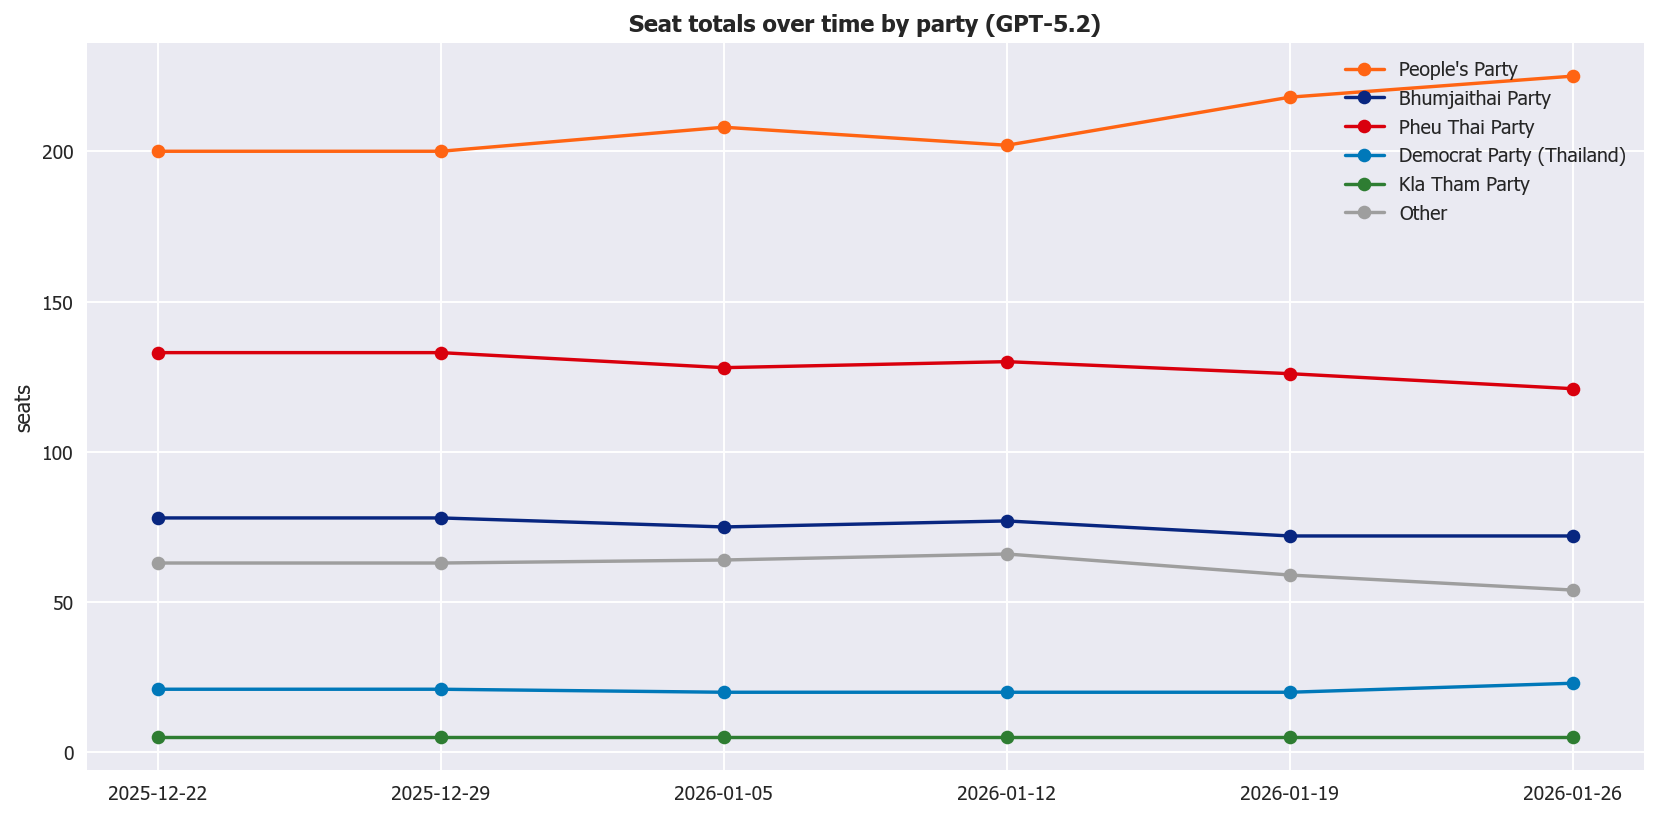

In [320]:
# One plot for all parties but with GPT-5.2 results
fcst_gpt52 = fcst[fcst['model'] == 'gpt-5.2']

plt.figure(figsize=(12,6))
for party, color in PARTY_COLORS.items():
    party_data = fcst_gpt52.pivot_table(index='week_start', values=party, aggfunc='mean')
    plt.plot(party_data.index, party_data[party], marker='o', label=party, color=color)
plt.title('Seat totals over time by party (GPT-5.2)')
plt.ylabel('seats')
plt.legend()
plt.tight_layout()
plt.show()

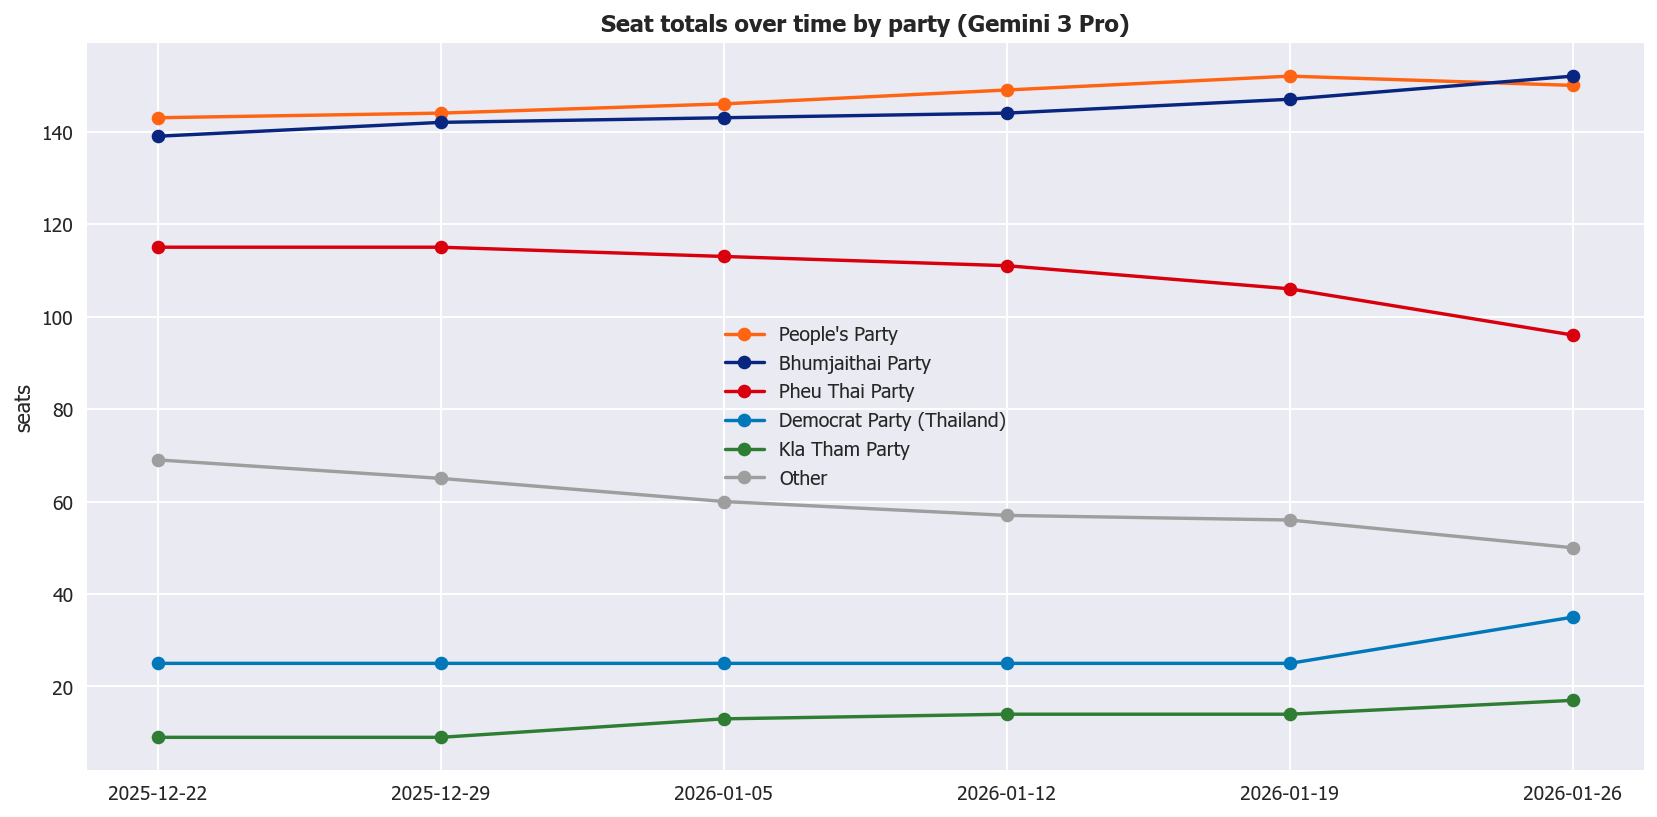

In [321]:
# One plot for all parties but with GPT-5.2 results
fcst_gemini3pro = fcst[fcst['model'] == 'gemini-3-pro-preview']

plt.figure(figsize=(12,6))
for party, color in PARTY_COLORS.items():
    party_data = fcst_gemini3pro.pivot_table(index='week_start', values=party, aggfunc='mean')
    plt.plot(party_data.index, party_data[party], marker='o', label=party, color=color)
plt.title('Seat totals over time by party (Gemini 3 Pro)')
plt.ylabel('seats')
plt.legend()
plt.tight_layout()
plt.show()

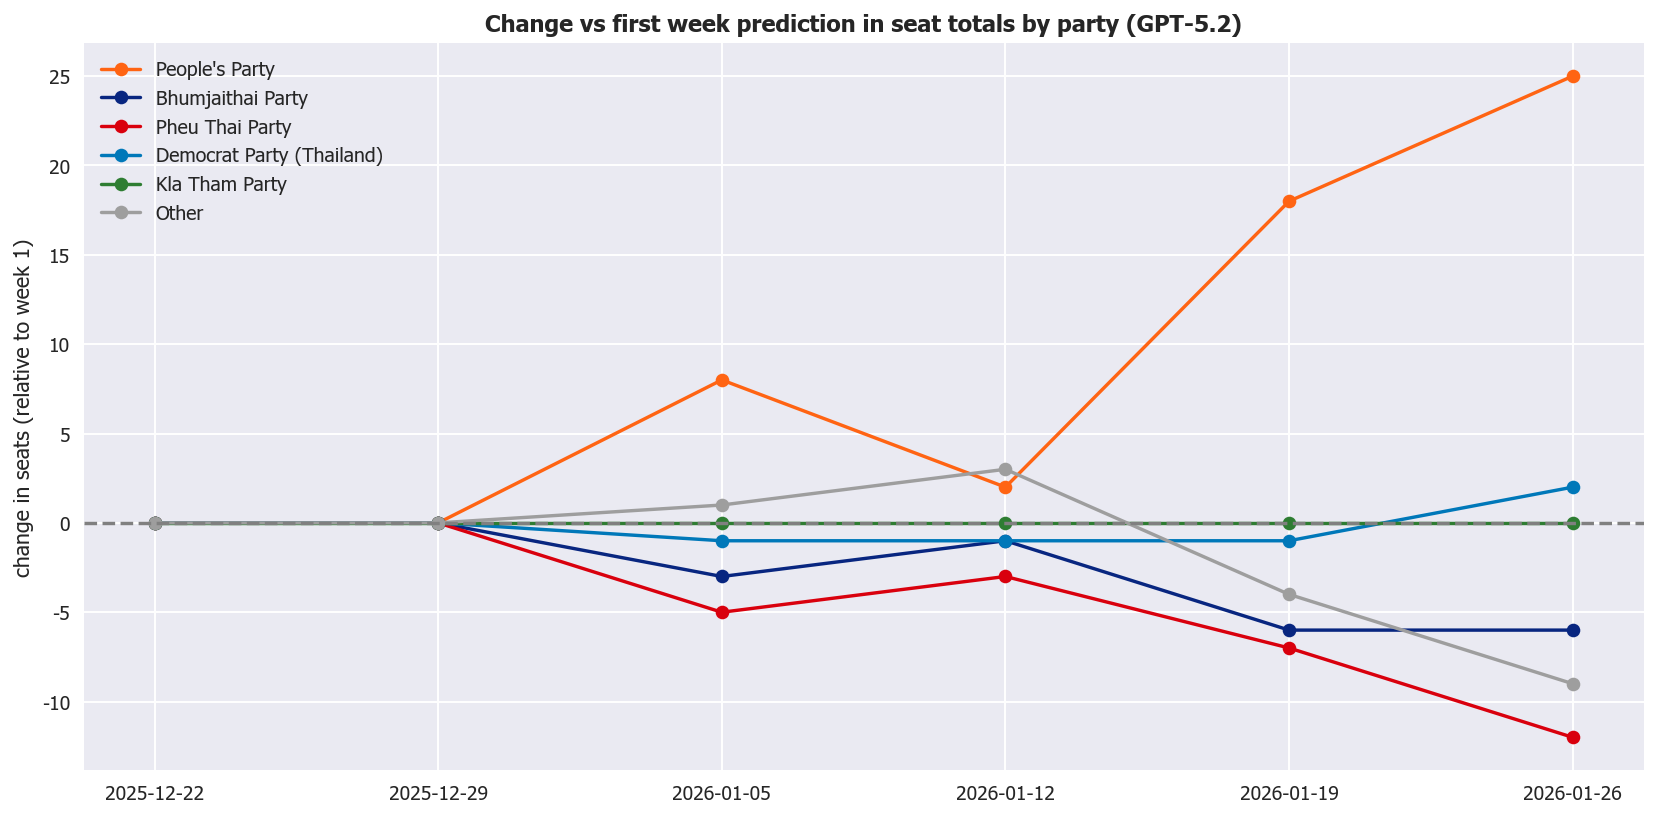

In [322]:
# Plot change vs first week prediction (center at 0)

fcst_gpt52_sorted = fcst_gpt52.sort_values('week_start')
party_cols = [c for c in fcst_gpt52.columns if c not in {'week_start','week_end','model','condition','path'}]

# Use the first week as baseline
baseline = fcst_gpt52_sorted.iloc[0]
fcst_gpt52_delta = fcst_gpt52_sorted.copy()
for party in party_cols:
    fcst_gpt52_delta[party] = fcst_gpt52_sorted[party] - baseline[party]

plt.figure(figsize=(12,6))
for party, color in PARTY_COLORS.items():
    if party not in party_cols:
        continue
    party_data = fcst_gpt52_delta.pivot_table(index='week_start', values=party, aggfunc='mean')
    plt.plot(party_data.index, party_data[party], marker='o', label=party, color=color)
plt.axhline(0, color='gray', linestyle='--')
plt.title('Change vs first week prediction in seat totals by party (GPT-5.2)')
plt.ylabel('change in seats (relative to week 1)')
plt.legend()
plt.tight_layout()
plt.show()


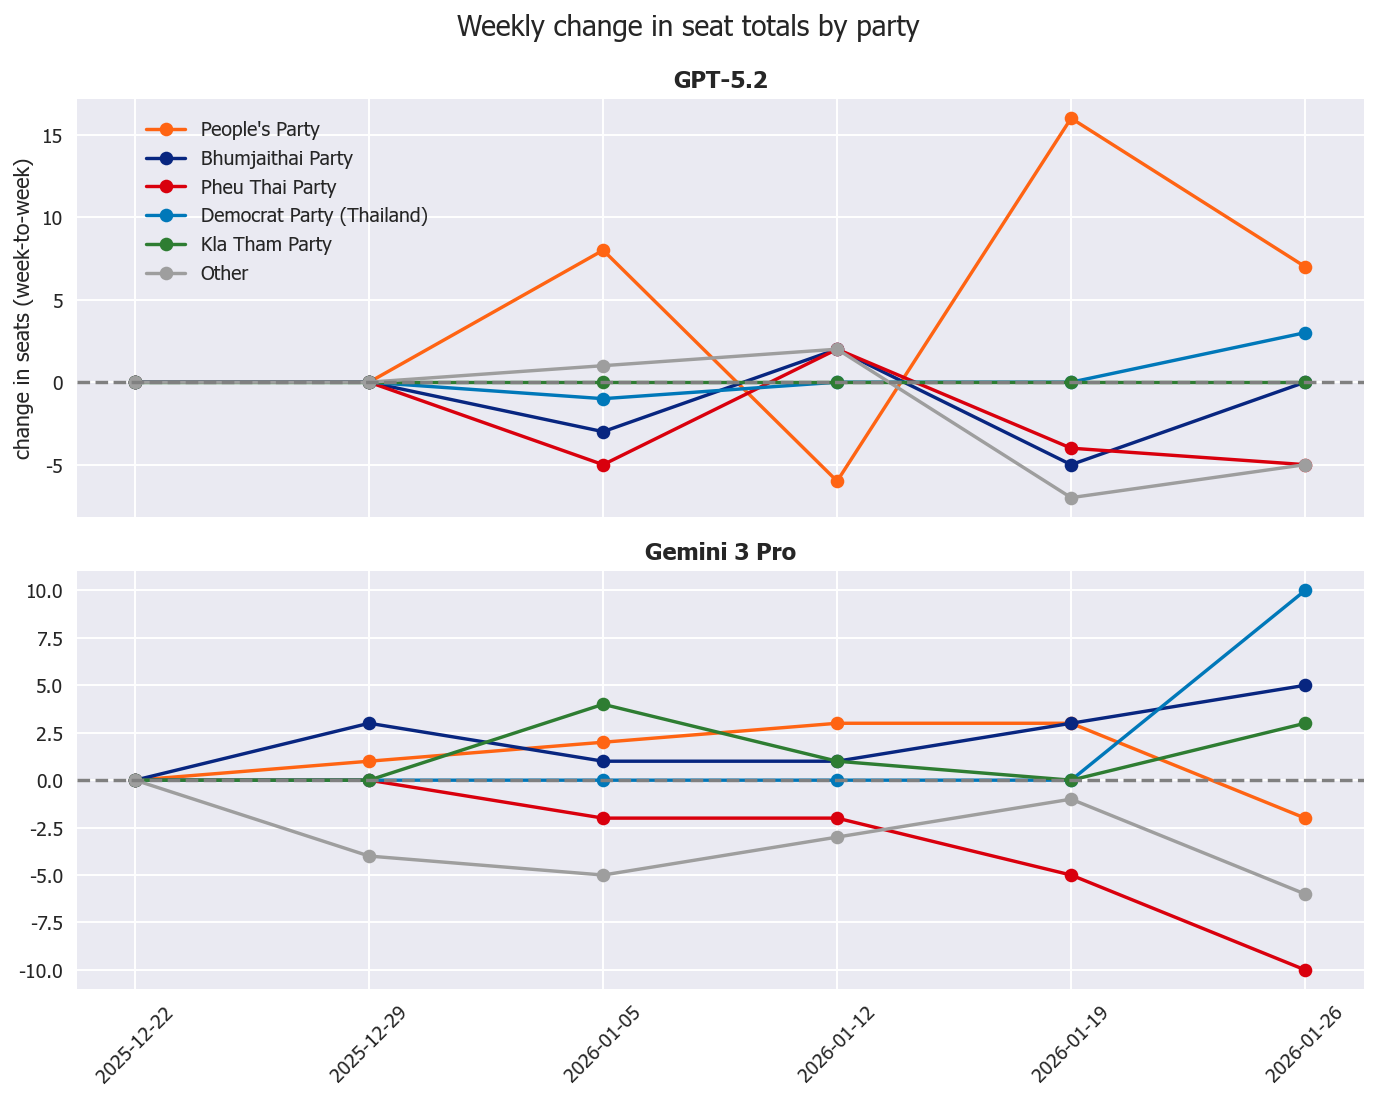

In [323]:
# Plot weekly change (week-by-week deltas) for GPT-5.2 and Gemini (subplot)

# GPT-5.2 weekly deltas
fcst_gpt52_sorted = fcst_gpt52.sort_values('week_start')
party_cols_gpt = [c for c in fcst_gpt52.columns if c not in {'week_start','week_end','model','condition','path'}]
fcst_gpt52_diff = fcst_gpt52_sorted.copy()
for party in party_cols_gpt:
    fcst_gpt52_diff[party] = fcst_gpt52_sorted[party].diff().fillna(0)

fcst_gemini3pro_sorted = fcst_gemini3pro.sort_values('week_start')
party_cols = [c for c in fcst_gemini3pro.columns if c not in {'week_start','week_end','model','condition','path'}]

fcst_gemini3pro_diff = fcst_gemini3pro_sorted.copy()
for party in party_cols:
    fcst_gemini3pro_diff[party] = fcst_gemini3pro_sorted[party].diff().fillna(0)

fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# GPT-5.2 subplot
ax = axes[0]
for party, color in PARTY_COLORS.items():
    if party not in party_cols_gpt:
        continue
    party_data = fcst_gpt52_diff.pivot_table(index='week_start', values=party, aggfunc='mean')
    ax.plot(party_data.index, party_data[party], marker='o', label=party, color=color)
ax.axhline(0, color='gray', linestyle='--')
ax.set_title('GPT-5.2')
ax.set_ylabel('change in seats (week-to-week)')

# Gemini subplot
ax = axes[1]
if not fcst_gemini3pro_diff.empty:
    for party, color in PARTY_COLORS.items():
        if party not in party_cols:
            continue
        party_data = fcst_gemini3pro_diff.pivot_table(index='week_start', values=party, aggfunc='mean')
        ax.plot(party_data.index, party_data[party], marker='o', label=party, color=color)
    ax.axhline(0, color='gray', linestyle='--')
    ax.set_title('Gemini 3 Pro')
else:
    ax.text(0.5, 0.5, 'No Gemini data loaded', ha='center', va='center')
    ax.set_title('Gemini 3 Pro')

# Shared styling
for ax in axes:
    ax.tick_params(axis='x', rotation=45)

# Single legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(0.1, 0.90), frameon=False)
plt.suptitle('Weekly change in seat totals by party')
plt.tight_layout()
plt.show()


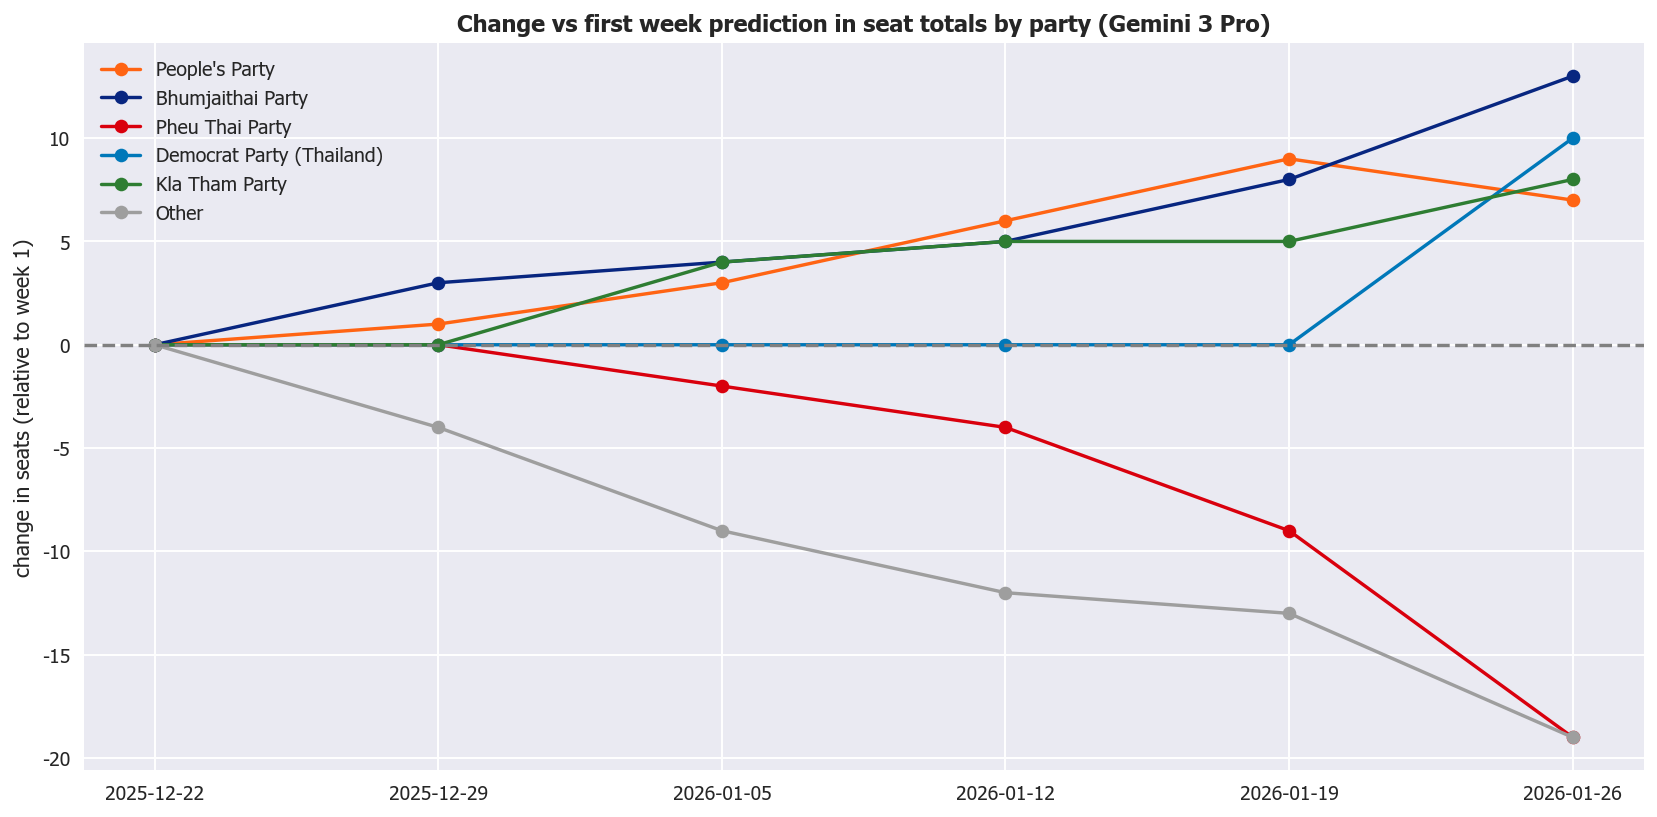

In [324]:
# Plot change vs first week prediction (center at 0)

fcst_gemini3pro_sorted = fcst_gemini3pro.sort_values('week_start')
party_cols = [c for c in fcst_gemini3pro.columns if c not in {'week_start','week_end','model','condition','path'}]

# Use the first week as baseline
baseline = fcst_gemini3pro_sorted.iloc[0]
fcst_gemini3pro_delta = fcst_gemini3pro_sorted.copy()
for party in party_cols:
    fcst_gemini3pro_delta[party] = fcst_gemini3pro_sorted[party] - baseline[party]

plt.figure(figsize=(12,6))
for party, color in PARTY_COLORS.items():
    if party not in party_cols:
        continue
    party_data = fcst_gemini3pro_delta.pivot_table(index='week_start', values=party, aggfunc='mean')
    plt.plot(party_data.index, party_data[party], marker='o', label=party, color=color)
plt.axhline(0, color='gray', linestyle='--')
plt.title('Change vs first week prediction in seat totals by party (Gemini 3 Pro)')
plt.ylabel('change in seats (relative to week 1)')
plt.legend()
plt.tight_layout()
plt.show()


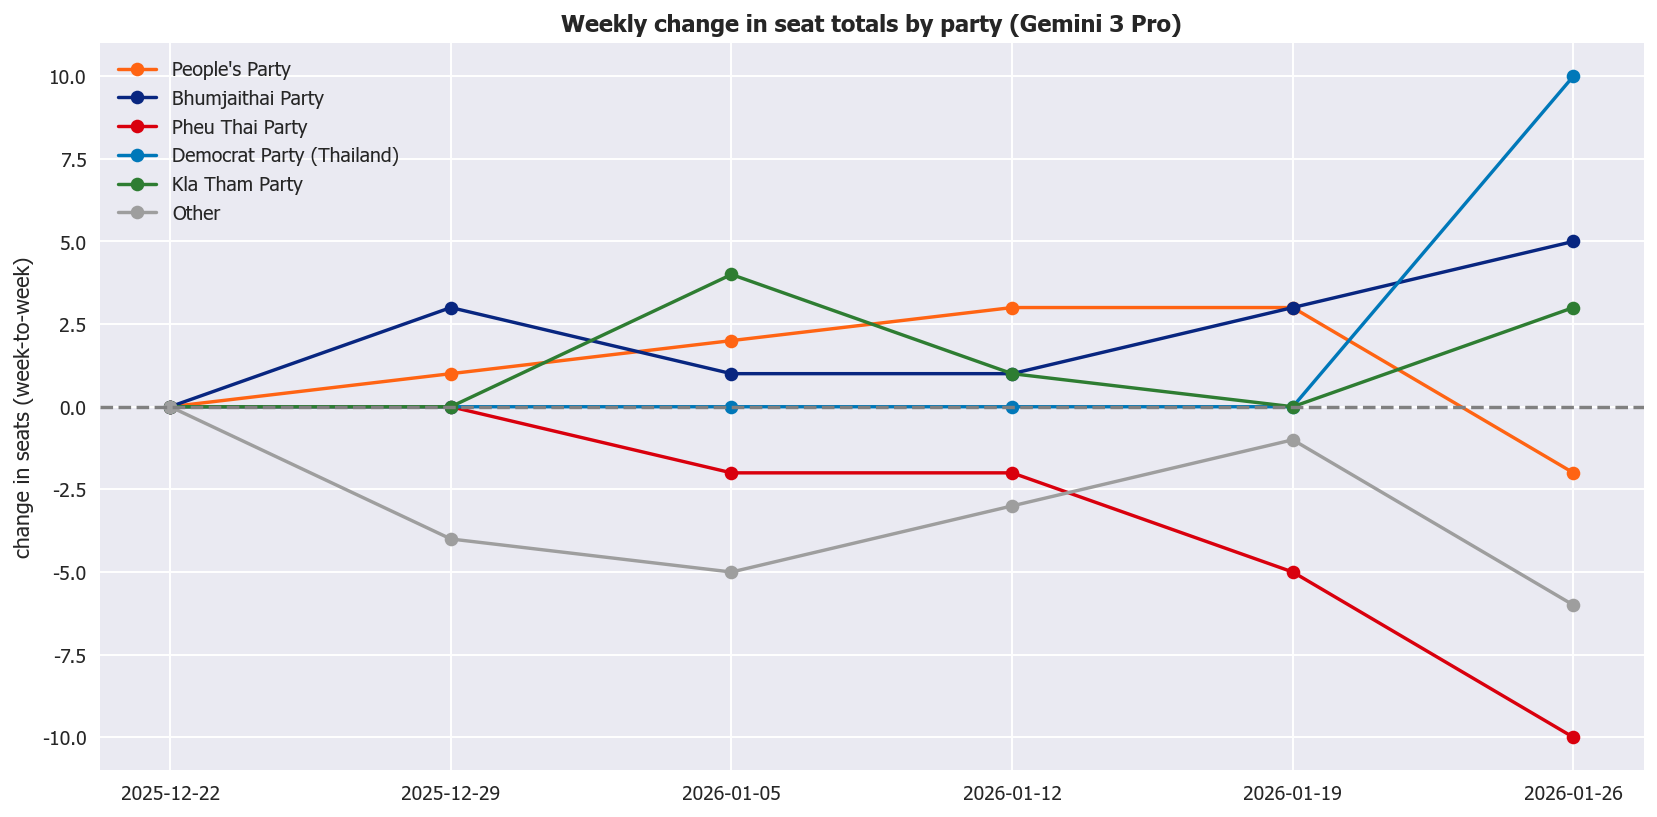

In [325]:
# Plot weekly change (week-by-week deltas)

fcst_gemini3pro_sorted = fcst_gemini3pro.sort_values('week_start')
party_cols = [c for c in fcst_gemini3pro.columns if c not in {'week_start','week_end','model','condition','path'}]

fcst_gemini3pro_diff = fcst_gemini3pro_sorted.copy()
for party in party_cols:
    fcst_gemini3pro_diff[party] = fcst_gemini3pro_sorted[party].diff().fillna(0)

plt.figure(figsize=(12,6))
for party, color in PARTY_COLORS.items():
    if party not in party_cols:
        continue
    party_data = fcst_gemini3pro_diff.pivot_table(index='week_start', values=party, aggfunc='mean')
    plt.plot(party_data.index, party_data[party], marker='o', label=party, color=color)
plt.axhline(0, color='gray', linestyle='--')
plt.title('Weekly change in seat totals by party (Gemini 3 Pro)')
plt.ylabel('change in seats (week-to-week)')
plt.legend()
plt.tight_layout()
plt.show()


## Week-over-week deltas

In [326]:
if not fcst.empty:
    party_cols = [c for c in fcst.columns if c not in {'week_start','week_end','model','condition','path'}]
    fcst_sorted = fcst.sort_values(['model','condition','week_start'])
    deltas = fcst_sorted.groupby(['model','condition'])[party_cols].diff()
    delta_df = pd.concat([fcst_sorted[['week_start','model','condition']], deltas], axis=1)
    delta_df.head()

## Final forecast analysis

This section summarizes the final (latest week) forecasted results for each model and condition.


In [327]:
# Identify the final week per model/condition
if fcst.empty:
    print('No forecast data loaded.')
else:
    # Ensure week_start is sortable as date
    fcst2 = fcst.copy()
    fcst2['week_start'] = pd.to_datetime(fcst2['week_start'])
    fcst2['week_end'] = pd.to_datetime(fcst2['week_end'])

    # Select latest week for each model/condition
    idx = fcst2.sort_values('week_start').groupby(['model','condition'])['week_start'].idxmax()
    final_fcst = fcst2.loc[idx].sort_values(['model','condition'])

    # Show final totals table
    party_cols = [c for c in final_fcst.columns if c not in {'week_start','week_end','model','condition','path'}]
    display(final_fcst[['model','condition','week_start','week_end'] + party_cols])


,model,condition,week_start,week_end,People's Party,Bhumjaithai Party,Pheu Thai Party,Democrat Party (Thailand),Kla Tham Party,Other
17,gemini-3-pro-preview,with_prior,2026-01-26,2026-01-31,150,152,96,35,17,50
4,gpt-5.2,with_prior,2026-01-26,2026-01-31,225,72,121,23,5,54


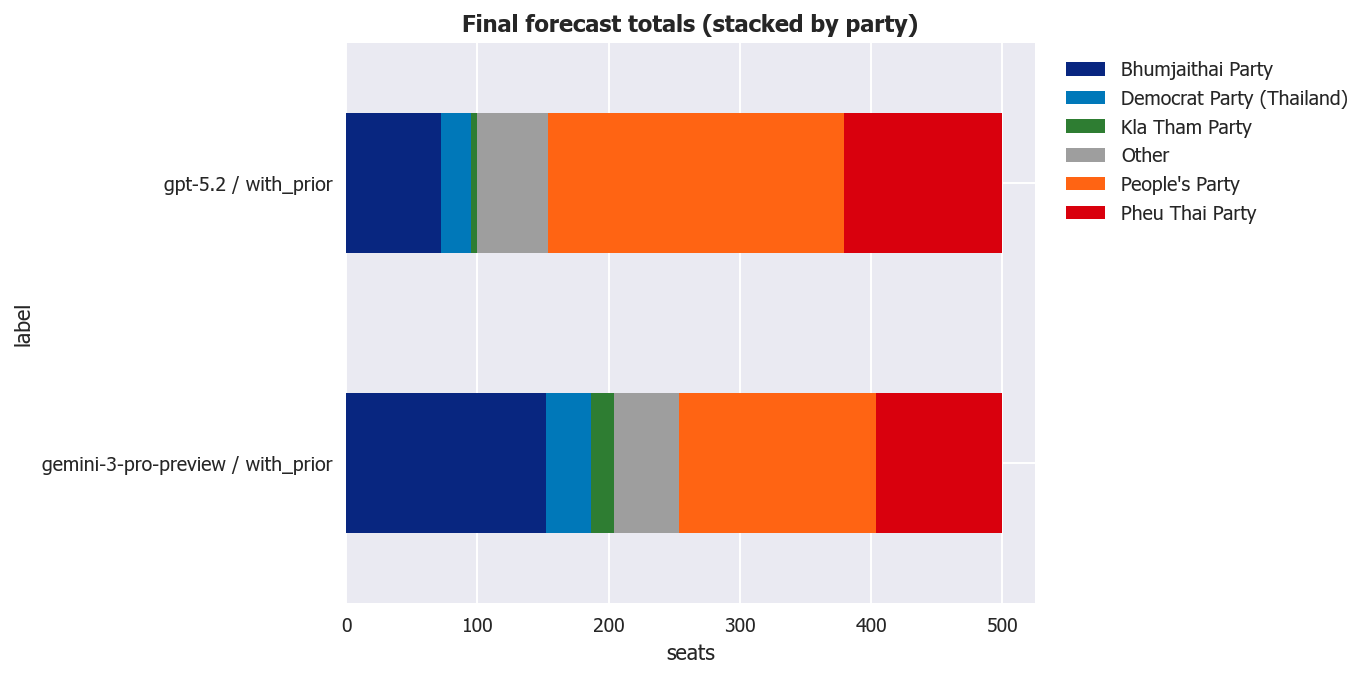

In [328]:
# Plot final totals by party for each model/condition
if not fcst.empty:
    final_fcst = final_fcst.copy()
    party_cols = [c for c in final_fcst.columns if c not in {'week_start','week_end','model','condition','path'}]
    final_long = final_fcst.melt(id_vars=['model','condition'], value_vars=party_cols, var_name='party', value_name='seats')

    # Horizontal bar chart, grouped by model/condition
    fig, ax = plt.subplots(figsize=(10, 5))
    # Create an ordering for y-axis
    final_long['label'] = final_long['model'] + ' / ' + final_long['condition']
    order = final_long['label'].drop_duplicates().tolist()

    # Plot each party as stacked bars
    pivot = final_long.pivot_table(index='label', columns='party', values='seats', aggfunc='sum').fillna(0)
    pivot = pivot.loc[order]
    colors = [PARTY_COLORS.get(p, '#999999') for p in pivot.columns]
    pivot.plot(kind='barh', stacked=True, ax=ax, color=colors)
    ax.set_title('Final forecast totals (stacked by party)')
    ax.set_xlabel('seats')
    ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.tight_layout()


## Final forecast (with prior): semicircle proportions

Semicircle charts for the latest **with_prior** forecast for **gpt-5.2** and **gemini-3-pro**. Parties are sorted by seat count.


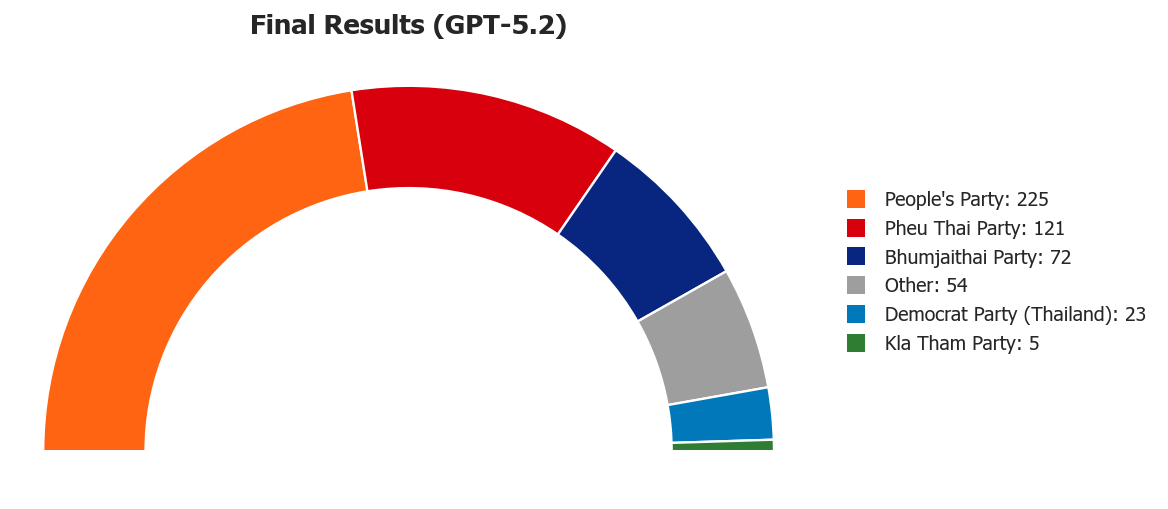

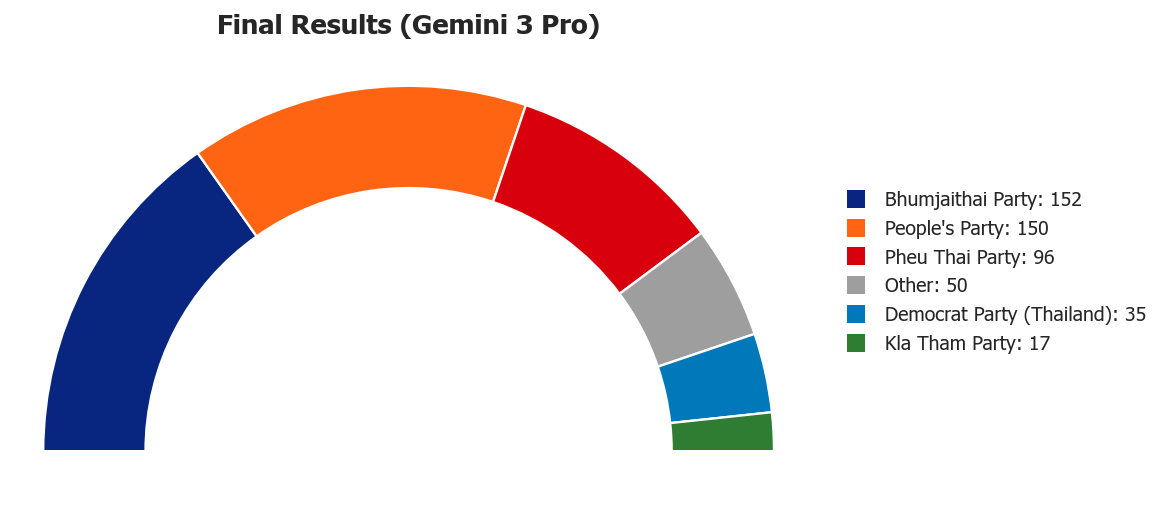

In [329]:
from matplotlib.patches import Wedge

# Medium-friendly styling for publication
plt.rcParams.update({
    'figure.dpi': 140,
    'axes.titlesize': 14,
    'axes.titleweight': 'bold',
    'font.size': 12,
})

def semicircle_plot(series, title):
    # series: pandas Series with party -> seats
    s = series.sort_values(ascending=False)
    total = s.sum()
    if total == 0:
        print(f'{title}: total is 0')
        return

    fig, ax = plt.subplots(figsize=(8.5, 4.8), facecolor='white')
    ax.set_facecolor('white')

    start = 180.0
    for party, seats in s.items():
        frac = seats / total
        end = start - 180.0 * frac
        color = PARTY_COLORS.get(party, '#999999')
        wedge = Wedge((0, 0), 1.0, end, start, width=0.28, facecolor=color, edgecolor='white', linewidth=1.2)
        ax.add_patch(wedge)
        start = end

    ax.set_aspect('equal')
    ax.set_xlim(-1.08, 1.08)
    ax.set_ylim(-0.12, 1.10)
    ax.axis('off')

    labels = [f"{p}: {int(v)}" for p, v in s.items()]
    handles = [plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=PARTY_COLORS.get(p, '#999999'), markersize=9) for p in s.index]
    ax.legend(handles, labels, loc='center left', bbox_to_anchor=(1.02, 0.5), ncol=1, frameon=False, handletextpad=0.5)
    ax.set_title(title, pad=8)
    plt.tight_layout()

# Build latest with_prior forecasts per model
if fcst.empty:
    print('No forecast data loaded.')
else:
    fcst2 = fcst.copy()
    fcst2['week_start'] = pd.to_datetime(fcst2['week_start'])
    party_cols = [c for c in fcst2.columns if c not in {'week_start','week_end','model','condition','path'}]

    def latest_with_prior(model_name):
        subset = fcst2[(fcst2['model'] == model_name) & (fcst2['condition'] == 'with_prior')]
        if subset.empty:
            return None
        row = subset.sort_values('week_start').iloc[-1]
        return row[party_cols]

    series_gpt = latest_with_prior('gpt-5.2')
    series_gem = latest_with_prior('gemini-3-pro')

    # Fallback for gemini preview model names
    if series_gem is None:
        gem_models = [m for m in fcst2['model'].unique() if 'gemini' in str(m)]
        if gem_models:
            series_gem = latest_with_prior(gem_models[0])

    if series_gpt is not None:
        semicircle_plot(series_gpt, 'Final Results (GPT-5.2)')
    else:
        print('No with_prior data for gpt-5.2')

    if series_gem is not None:
        title_model = 'gemini-3-pro' if 'gemini-3-pro' in fcst2['model'].unique() else (gem_models[0] if 'gem_models' in locals() and gem_models else 'gemini')
        semicircle_plot(series_gem, f'Final Results (Gemini 3 Pro)')
    else:
        print('No with_prior data for gemini-3-pro')


In [330]:
# Rank parties by final total per model/condition
if not fcst.empty:
    # Ensure final_fcst exists
    if 'final_fcst' not in locals():
        fcst2 = fcst.copy()
        fcst2['week_start'] = pd.to_datetime(fcst2['week_start'])
        fcst2['week_end'] = pd.to_datetime(fcst2['week_end'])
        idx = fcst2.sort_values('week_start').groupby(['model','condition'])['week_start'].idxmax()
        final_fcst = fcst2.loc[idx].sort_values(['model','condition'])

    party_cols = [c for c in final_fcst.columns if c not in {'week_start','week_end','model','condition','path'}]
    if len(party_cols) < 2:
        print('Not enough party columns to rank.')
    else:
        ranks = []
        for _, row in final_fcst.iterrows():
            totals = {p: row[p] for p in party_cols}
            ordered = sorted(totals.items(), key=lambda x: x[1], reverse=True)
            if len(ordered) < 2:
                continue
            ranks.append({
                'model': row['model'],
                'condition': row['condition'],
                'winner': ordered[0][0],
                'winner_seats': ordered[0][1],
                'runner_up': ordered[1][0],
                'runner_up_seats': ordered[1][1],
            })
        ranks_df = pd.DataFrame(ranks)
        display(ranks_df)


,model,condition,winner,winner_seats,runner_up,runner_up_seats
0,gemini-3-pro-preview,with_prior,Bhumjaithai Party,152,People's Party,150
1,gpt-5.2,with_prior,People's Party,225,Pheu Thai Party,121
